In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns

# Install imbalanced-learn if not installed
try:
    from imblearn.over_sampling import RandomOverSampler
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install imbalanced-learn   
    from imblearn.over_sampling import RandomOverSampler

2024-12-17 02:14:23.703729: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 02:14:23.705967: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-17 02:14:23.737000: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-17 02:14:23.774869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734387263.813943   74030 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734387263.82

In [2]:
# Step 1: Load Data
categories = ['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']
data_paths = {
    category: glob.glob(f"./augmented-alzheimer-mri-dataset-v2/data/val/{category}/*")
    for category in categories
}

data = []
labels = []

for i, category in enumerate(categories):
    for file_path in data_paths[category]:
        data.append(file_path)
        labels.append(i)

In [3]:

# Step 2: Handle Data Imbalance (Oversampling)
data = np.array(data)   
labels = np.array(labels)

# Oversample minority classes
ros = RandomOverSampler(random_state=42)
data_resampled, labels_resampled = ros.fit_resample(data.reshape(-1, 1), labels)
data_resampled = data_resampled.ravel()

In [4]:
# Step 3: Train-test Split
data_train, data_val, labels_train, labels_val = train_test_split(
    data_resampled, labels_resampled, test_size=0.2, stratify=labels_resampled, random_state=42
)

In [5]:
# Step 4: Data Preprocessing
def preprocess_image(file_path):
    import tensorflow as tf
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image

def create_dataset(file_paths, labels):
    import tensorflow as tf
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset



In [6]:
train_dataset = create_dataset(data_train, labels_train)
val_dataset = create_dataset(data_val, labels_val)


W0000 00:00:1734387266.435264   74030 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
# Step 5: Build the MobileNetV2 Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [8]:
# Step 6: Training the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 213s 658ms/step - accuracy: 0.4983 - loss: 1.1457 - val_accuracy: 0.6727 - val_loss: 0.6981
Epoch 2/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 205s 642ms/step - accuracy: 0.6562 - loss: 0.7346 - val_accuracy: 0.6973 - val_loss: 0.6381
Epoch 3/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 194s 605ms/step - accuracy: 0.6942 - loss: 0.6665 - val_accuracy: 0.7309 - val_loss: 0.5793
Epoch 4/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 199s 623ms/step - accuracy: 0.7109 - loss: 0.6259 - val_accuracy: 0.7695 - val_loss: 0.5449
Epoch 5/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 201s 629ms/step - accuracy: 0.7310 - loss: 0.5894 - val_accuracy: 0.7523 - val_loss: 0.5342
Epoch 6/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 201s 629ms/step - accuracy: 0.7424 - loss: 0.5720 - val_accuracy: 0.7836 - val_loss: 0.4933
Epoch 7/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 202s 630ms/step - accuracy: 0.7630 - loss: 0.5383 - val_accuracy: 0.7949 - val_loss: 0.4823
Epoch 8/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 193s 603ms/step - accuracy: 0.7687 -

In [9]:
# Step 7: Evaluate the Model
eval_results = model.evaluate(val_dataset)
print(f"Validation Accuracy: {eval_results[1] * 100:.2f}%")

80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 519ms/step - accuracy: 0.8755 - loss: 0.2967
Validation Accuracy: 86.99%


In [10]:
# Step 8: Performance Metrics
# Predictions on validation set
y_true = labels_val
y_pred = np.argmax(model.predict(val_dataset), axis=-1)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Validation Accuracy: {accuracy * 100:.2f}%')
print(f'Validation Precision: {precision * 100:.2f}%')
print(f'Validation Recall: {recall * 100:.2f}%')
print(f'Validation F1-Score: {f1 * 100:.2f}%')

80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 506ms/step
Validation Accuracy: 86.99%
Validation Precision: 87.04%
Validation Recall: 86.99%
Validation F1-Score: 86.98%


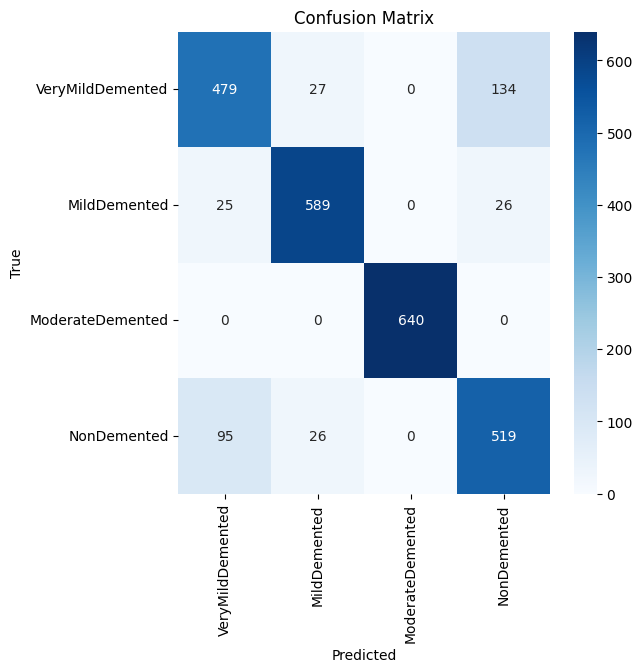

In [11]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

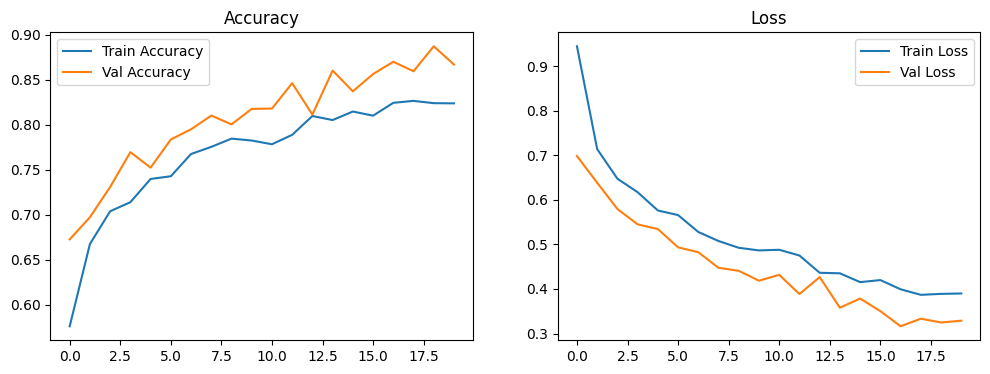

In [12]:
# Step 9: Plot Accuracy and Loss Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [13]:
# Step 10: Save the Model
model.save('alzheimer_mobilenetv2_model.h5')

In [14]:
# Step 11: Fine-Tuning the Model
# Unfreeze Top Layers of MobileNetV2
for layer in base_model.layers[:100]:  # Keep lower layers frozen
    layer.trainable = False
for layer in base_model.layers[100:]:  # Unfreeze top layers
    layer.trainable = True

In [15]:
# Recompile the Model
from tensorflow.keras.optimizers import Adam

fine_tune_lr = 1e-5
model.compile(optimizer=Adam(learning_rate=fine_tune_lr), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [16]:
# Fine-tune the Model
history_fine_tune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,  # Additional epochs for fine-tuning
    callbacks=[early_stopping]
)

Epoch 1/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 310s 946ms/step - accuracy: 0.5167 - loss: 7.7060 - val_accuracy: 0.7184 - val_loss: 0.7921
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 297s 929ms/step - accuracy: 0.6905 - loss: 1.0683 - val_accuracy: 0.7141 - val_loss: 0.7944
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 299s 934ms/step - accuracy: 0.7388 - loss: 0.6215 - val_accuracy: 0.6918 - val_loss: 0.8929
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 288s 902ms/step - accuracy: 0.7881 - loss: 0.4861 - val_accuracy: 0.7129 - val_loss: 0.7755
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 295s 923ms/step - accuracy: 0.8180 - loss: 0.4130 - val_accuracy: 0.7363 - val_loss: 0.6718


In [17]:
# Evaluate Fine-tuned Model
eval_results_fine_tune = model.evaluate(val_dataset)
print(f"Fine-tuned Validation Accuracy: {eval_results_fine_tune[1] * 100:.2f}%")

80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 519ms/step - accuracy: 0.7267 - loss: 0.7486
Fine-tuned Validation Accuracy: 71.84%


In [18]:
# Performance Metrics after Fine-tuning
y_true_fine_tune = labels_val
y_pred_fine_tune = np.argmax(model.predict(val_dataset), axis=-1)

accuracy_fine_tune = accuracy_score(y_true_fine_tune, y_pred_fine_tune)
precision_fine_tune = precision_score(y_true_fine_tune, y_pred_fine_tune, average='weighted')
recall_fine_tune = recall_score(y_true_fine_tune, y_pred_fine_tune, average='weighted')
f1_fine_tune = f1_score(y_true_fine_tune, y_pred_fine_tune, average='weighted')

print(f'Fine-Tuned Validation Accuracy: {accuracy_fine_tune * 100:.2f}%')
print(f'Fine-Tuned Validation Precision: {precision_fine_tune * 100:.2f}%')
print(f'Fine-Tuned Validation Recall: {recall_fine_tune * 100:.2f}%')
print(f'Fine-Tuned Validation F1-Score: {f1_fine_tune * 100:.2f}%')

80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 514ms/step
Fine-Tuned Validation Accuracy: 71.84%
Fine-Tuned Validation Precision: 78.88%
Fine-Tuned Validation Recall: 71.84%
Fine-Tuned Validation F1-Score: 71.24%


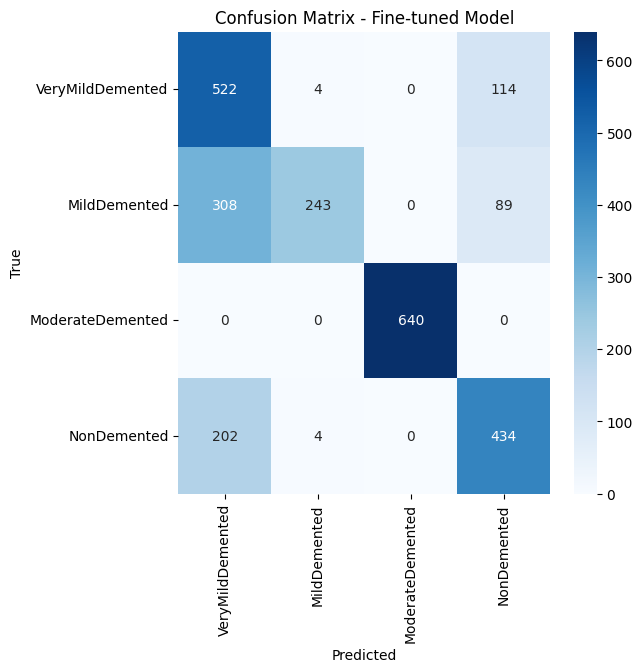

In [19]:
# Confusion Matrix after Fine-tuning
cm_fine_tune = confusion_matrix(y_true_fine_tune, y_pred_fine_tune)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_fine_tune, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Fine-tuned Model')
plt.show()

In [20]:

# Save the fine-tuned model
model.save('fine_tuned_mobilenetv2.h5')

# Save the trained model in .h5 format
model.save('fine_tuned_mobilenetv2-1.h5', save_format='h5')

model.save('fine_tuned_mobilenetv2.keras')